# Import libraries and data

First, it is connected to the repository where the data is stored, on the one hand the raw market data, from which the patterns are labeled. On the other hand, also to store the labeled patterns that will later be used to train a neural network.

Next, the necessary libraries for data processing and visualization are imported.

In [ ]:
# It connects to the repository to obtain the necessary data to be used throughout the execution of this google colab document.
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#Utils
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import random
from scipy import stats
from sklearn.linear_model import LinearRegression

In [ ]:
#Library for visualization of data on candlestick charts
!pip install mpl_finance
import mpl_finance as mpf

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/




---



# Extra functions

Necessary functions are defined for the process of labeling the patterns and transforming them. On the one hand, the function "pattern_show_image" is used to observe the pattern identified from trend rules and to confirm visually by the user if it is correct or not. 

Then we present the function "image_gaf", which function is used to visualize the image obtained from a time series, using the Gramian Angular Field method.


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:36: DeprecationWarning: `np.float` is a deprecated alias for the builtin `float`. To silence this warning, use `float` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.float64` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations


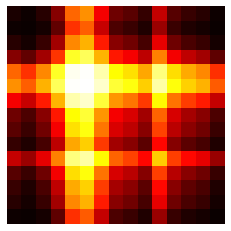

In [ ]:
# function to view candlestick chart of labeled pattern
def pattern_show_image(signal, target):           
  fontsize=12
  plt.rcParams['xtick.labelsize'] = fontsize  
  plt.rcParams['ytick.labelsize'] = fontsize 
  plt.rcParams['axes.titlesize'] = fontsize           
  fig = plt.figure(figsize=(10, 10))
  ax = plt.subplot2grid((1, 1), (0, 0))           
  ax.set_xticks(range(10))
  ax.set_xticklabels(target.index)                     
  arr = np.c_[range(target.shape[0]), target[['open', 'max', 'min', 'close']].values]
  mpf.candlestick_ohlc(ax, arr, width=0.5, alpha=1, colordown='#ff1717', colorup='#53c156')          
  locs, labels = plt.xticks() 
  plt.setp(labels , rotation = 45)
  plt.grid()
  ax.legend(loc = 'best', prop = {'size': fontsize})
  title_name = signal
  ax.set_title(title_name)
  fig.subplots_adjust(bottom = 0.25)       
  name = signal
  plt.axis('off')
  plt.show()


# method that prints one image on the screen using GAF
def image_gaf(serie):
    max = np.amax(serie)
    min = np.amin(serie)
    result = serie_tiempo_gaf(serie,max,min)
    plt.imshow(result, cmap='hot', interpolation='nearest')
    plt.axis('off')
    plt.show()


# test, see image of gaf - opening values of japanese candlesticks in a double top pattern
serie = np.array(['1.44697','1.44678','1.4471','1.44761','1.44802','1.44803','1.4479','1.44752','1.44742','1.44721','1.4478','1.44741','1.44722','1.4471','1.44677']).astype(np.float)

image_gaf(serie)


# Obtain Japanese candlestick information and convert them to images using GAF

In this cell are defined three functions necessary to transform the time series of the Japanese candlesticks to images. For this, the time series structure of each pattern is processed to a multidimensional array with the characteristics of the Japanese candlesticks (open, min, max, close). 
Then they are processed by applying the GAF method and adding them to a structured array for further handling.


In [ ]:
# GAF function, converts a time series to a Gramian matrix.
def serie_tiempo_gaf(serie,valueMax,valueMin):
  if valueMax == valueMin:
      mGaf = np.zeros((len(serie), len(serie)))
  else:
      serieNorm = np.array((serie-valueMin) / (valueMax-valueMin))
      serieNormArc = np.arccos(serieNorm)
      mGaf = np.zeros((len(serieNorm), len(serieNorm)))
      for f in range(len(serieNorm)):
          for c in range(len(serieNorm)):
              mGaf[f, c] = np.cos(serieNormArc[f] + serieNormArc[c])
  return mGaf


# Function that receives a set of patterns with a predefined structure and that are converted through the GAF method.
def create_gaf(serie_pattern):
  data = serie_pattern.copy()
  gaf = np.zeros((data.shape[0], data.shape[1], data.shape[1], data.shape[2]))
  for i in range(data.shape[0]):
      for c in range(data.shape[2]):
          oneCat = data[i, :, c]
          maxV = np.amax(oneCat)
          minV = np.amin(oneCat)
          result = serie_tiempo_gaf(oneCat, maxV, minV)
          gaf[i, :, :, c] = result
  return gaf


# Function that returns a structured data series with the candlestick data for each pattern.
# Given from the data of all the patterns recorded.
def create_serie(df_pattern):
  total = int(df_pattern.shape[0] / window )
  serie = np.zeros((total, window, 4)) 
  for N in range(total):
    df = df_pattern.loc[(df_pattern.index >= (N*window)) & (df_pattern.index < (N*window + window))]
    serie[N, :, 0] = df['open']
    serie[N, :, 1] = df['max']
    serie[N, :, 2] = df['min']
    serie[N, :, 3] = df['close']
  return serie
 





---



# Red CNN

The class of a convolutional neural network model is defined, in order to create an instance of it on which to work, establishing its characteristics and then training the model with the labeled data to identify the categorized patterns.

In [ ]:
from sklearn.model_selection import train_test_split
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

# Class to instantiate a CNN model
class modelCNN(object):

    # Sets the instance variables
    def __init__(self, data_x, data_y):     
        self.model = None
        self.input_shape = None
        self.label_shape = None
        self.train_history = None
        self.data_x, self.data_y = data_x, data_y 
        self.X_train, self.y_train, self.X_test, self.y_test = None, None, None, None
        self. y_categoricalTrain, self.y_categoricalTest = None, None 

    # Divides the data into a test set and a test set     
    def process(self):
        self.X_train, self.X_test, self.y_train, self.y_test = train_test_split (self.data_x, self.data_y, test_size= 0.3, random_state = 42)
        self. y_categoricalTrain, self.y_categoricalTest = np_utils.to_categorical(self.y_train), np_utils.to_categorical(self.y_test)
        self.input_shape = self.X_train[0].shape
        self.label_shape = self. y_categoricalTrain.shape[1]
    
    # Set the layers and their characteristics that make up the CNN model
    def build(self):
        self.model = Sequential()
        self.model.add(Conv2D(filters=32, kernel_size=(2, 2), padding='same', input_shape = self.input_shape, activation='relu')) 
        self.model.add(MaxPooling2D(pool_size=(2, 2)))               
        self.model.add(Conv2D(filters=32, kernel_size=(2, 2), padding='same', activation='relu'))
        self.model.add(MaxPooling2D(pool_size=(2, 2)))   
        self.model.add(Dropout(0.25))                                                                                
        self.model.add(Flatten())
        self.model.add(Dense(128, activation='relu'))                                               
        self.model.add(Dropout(0.5))
        self.model.add(Dense(self.label_shape, activation='softmax'))                                            
        print(self.model.summary())                                                                               

    # Training of the model created with the processed data
    def train(self, split):
        self.model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy']) 
        self.train_history = self.model.fit(x = self.X_train, y = self.y_categoricalTrain, validation_split = split, shuffle=True, epochs = 50, batch_size = 150, verbose = 2)      
  
    # Prediction for a specific value with the trained model
    def predictTest(self,dataX):
        prediction = self.model.predict(dataX)
        print(prediction)
        #print(pd.crosstab(self.y_test, prediction, rownames=['label'], colnames=['predict']))
               
    # Save the created/trained model
    def save(self, filename):
        self.model.save(filename)

    # Displays training history
    def show_train_history(self, train_history, train, validation):
        plt.figure()
        plt.plot(train_history.history[train])
        plt.plot(train_history.history[validation])
        plt.title('Train History')
        plt.ylabel(train)
        plt.xlabel('Epoch')
        plt.legend(['train', 'validation'], loc='upper left')
        plt.show()
        
    # Prints out the accuracy values after the delivery it has had
    def show(self):
        self.show_train_history(self.train_history, 'loss', 'val_loss')
        self.show_train_history(self.train_history, 'accuracy', 'val_accuracy')
        score = self.model.evaluate(self.X_test, self.y_categoricalTest)
        print('Score of the Testing Data: {}'.format(score))
        






# Processing of the data using GAF and training of a CNN pattern identification model

For the creation of the model capable of identifying the labeled patterns, we proceed in this cell to occupy the previous class and the GAF functions, together with the generated data. In this way, we start loading the data of the categorized patterns from the repository to be processed with the functions of the previous cells. In this way, the data are transformed to images by the GAF method, which pass through a function that prepares them with the necessary format to enter the CNN. 
After processing the data, an instance of the CNN model is created by passing the categorized values of the patterns to be identified, they are processed in the instance and the layers that the model will have to be trained are built. Finally, the network is trained and the model is downloaded for later use. It is also worth mentioning that during the training and at the end of it, the information of how much the network learns is shown.

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 32)        544       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 32)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 14, 14, 32)        4128      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 7, 7, 32)         0         
 2D)                                                             
                                                                 
 dropout_2 (Dropout)         (None, 7, 7, 32)          0         
                                                                 
 flatten_1 (Flatten)         (None, 1568)             

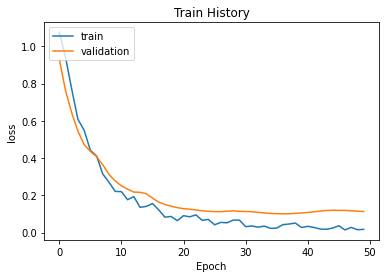

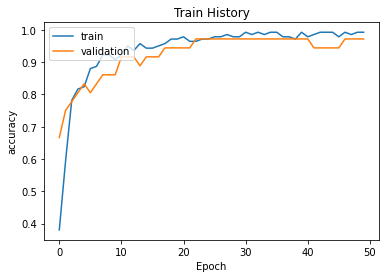

3/3 [==============================] - 0s 5ms/step - loss: 0.1578 - accuracy: 0.9610
Score of the Testing Data: [0.157833531498909, 0.9610389471054077]


In [ ]:
# Function that creates a CNN model and trains it with the labeled data, at the end it displays the training results.
def cnn(dataDic):
  x_data = dataDic['data']
  y_target = dataDic['target']
  model = modelCNN(x_data, y_target) 
  model.process()
  model.build()
  model.train(0.2)
  model.show()

  # Save model
  name = 'model_pattern'
  load_model = 'CNN_' + name + '.h5'
  model.save(load_model)

# Function that structures the data sets for use in the neural network.
# For each set, it is labeled differently from another one
def process_data(d1,d2,d3):
  total = d1.shape[0] + d2.shape[0] + d3.shape[0]
  xSerie = np.zeros((total, window, window, 4))
  xSerie[0:d1.shape[0] - 1, :, :, :] = d1[0:d1.shape[0] - 1, :, :, :] 
  xSerie[d1.shape[0]: d1.shape[0] + d2.shape[0] - 1, :, :, :] = d2[0:d2.shape[0] - 1, :, :, :] 
  xSerie[d1.shape[0] + d2.shape[0]:total -1 , :, :, :] = d3[0:d3.shape[0] - 1, :, :, :] 
  yData = []
  ls = [0] * d1.shape[0] 
  yData.extend(ls)
  ls = [1] * d2.shape[0]
  yData.extend(ls)
  ls = [2] * d3.shape[0]
  yData.extend(ls)
  ySerie = np.array(yData)
  dataDic = {'data': xSerie, 'target': ySerie}
  return dataDic



# Size of window in which it is predisposed to identify market patterns
window = 28

# Loads labeled pattern data
# Each set of patterns is structured into a time series that can be processed, to be transformed by the GAF method.
c_h_eurusd = create_gaf(create_serie(pd.read_csv('/content/drive/MyDrive/Tesis de grado/datos/Procesados/Obtenidos/S&H/patron_cabezaHombros_23_23_EURUSD.csv')))
c_h_gbpusd = create_gaf(create_serie(pd.read_csv('/content/drive/MyDrive/Tesis de grado/datos/Procesados/Obtenidos/S&H/patron_cabezaHombros_26_26_GBPUSD.csv')))
c_h_usdjpy = create_gaf(create_serie(pd.read_csv('/content/drive/MyDrive/Tesis de grado/datos/Procesados/Obtenidos/S&H/patron_cabezaHombros_31_31_USDJPY.csv')))
c_h_eurchf = create_gaf(create_serie(pd.read_csv('/content/drive/MyDrive/Tesis de grado/datos/Procesados/Obtenidos/S&H/patron_cabezaHombros_8_8_USDCHF.csv')))
tt_eurusd = create_gaf(create_serie(pd.read_csv('/content/drive/MyDrive/Tesis de grado/datos/Procesados/Obtenidos/dobleTop/patron_dobleT_21_21_GBPUSD.csv')))
tt_gbpusd = create_gaf(create_serie(pd.read_csv('/content/drive/MyDrive/Tesis de grado/datos/Procesados/Obtenidos/dobleTop/patron_dobleT_21_21_USDCHF.csv')))
tt_usdjpy = create_gaf(create_serie(pd.read_csv('/content/drive/MyDrive/Tesis de grado/datos/Procesados/Obtenidos/dobleTop/patron_dobleT_22_22_USDJPY.csv')))
tt_eurchf = create_gaf(create_serie(pd.read_csv('/content/drive/MyDrive/Tesis de grado/datos/Procesados/Obtenidos/dobleTop/patron_dobleT_23_23_EURUSD.csv')))
rd_eurusd = create_gaf(create_serie(pd.read_csv('/content/drive/MyDrive/Tesis de grado/datos/Procesados/Obtenidos/patron_random_80_80_EURUSD.csv')))

# Data from patterns that were tagged in parts are joined into a single set per tag
pattern_c_h_all = np.concatenate((c_h_eurusd, c_h_gbpusd, c_h_usdjpy, c_h_eurchf))
pattern_tt_all = np.concatenate((tt_eurusd, tt_gbpusd, tt_usdjpy, tt_eurchf))

# Call to the function that creates and trains the network, passing the processed data from the labeled dataset
cnn(process_data(pattern_c_h_all,pattern_tt_all, rd_eurusd))





---





---



# Functions for labeling 

In this cell the parameters and functions used for the processing of the financial market time series over a period of ten years are configured. To process this data and obtain the patterns to be used to train the network, the first step was to establish the window for identifying the patterns, as well as the time span to be taken into account, set in eighteen, and the number of candlesticks to be processed.

Then we defined the characteristics of the proportions of the trends that each pattern would have in order to define it according to its characteristics in the functions below. In the functions are defined both the functions to find according to the characteristics that define each pattern and to indicate the possible occurrence of one of them. Necessary functions are used for this, such as identifying the trend and defining it as a downtrend or an uptrend.

In [ ]:
#var
window_range = 28 

end_first_stretch_dt = 5
end_second_stretch_dt = 8
end_third_stretch_dt = 11
end_length_dt = 5
length_valle_dt = 3

end_first_stretch_sh = 7
end_second_stretch_sh = 11
end_third_stretch_sh = 15
end_fourth_stretch_sh = 19
end_fifth_stretch_sh = 23
end_length_sh = 7
length_valle_sh = 4

# Set the values necessary to define the characteristics of the searched pattern in a specific window range
def set_values_dt(window):
  if window % 2 == 1 or window < 16:
    return 1

  global end_first_stretch_dt
  global end_second_stretch_dt
  global end_third_stretch_dt
  global end_length_dt
  global length_valle_dt
  global window_range

  reservation = 2 
  aux = int(((window/2)-reservation)/2)
  auxr = int((window - aux * 4) /2)
  end_first_stretch_dt = aux + auxr
  end_second_stretch_dt = end_first_stretch_dt + aux
  end_third_stretch_dt = end_second_stretch_dt + aux
  end_length_dt = int(end_first_stretch_dt)
  length_valle_dt = int(aux)
  window_range = window
  return 0  


# Set the values necessary to define the characteristics of the searched pattern in a specific window range
def set_values_sh(window):
  if window % 2 == 1 or window < 16:
    return 1

  global end_first_stretch_sh
  global end_second_stretch_sh
  global end_third_stretch_sh
  global end_fourth_stretch_sh
  global end_fifth_stretch_sh
  global end_length_sh
  global length_valle_sh
  global window_range
  
  reservation = 2 
  length_valle_sh = int((window-reservation)/6)  
  end_length_sh = int(  (window - length_valle_sh*6)/2   ) 
  
  end_first_stretch_sh = end_length_sh + length_valle_sh
  end_second_stretch_sh = end_first_stretch_sh + length_valle_sh 
  end_third_stretch_sh = end_second_stretch_sh + length_valle_sh 
  end_fourth_stretch_sh = end_third_stretch_sh + length_valle_sh
  end_fifth_stretch_sh = end_fourth_stretch_sh + length_valle_sh
  window_range = window
  return 0 

# Determines whether the existence of a pattern is possible according to the definition of its formation, given from a series of data, according to the length of the window.
def head_shoulders(series):
        y = series.values.reshape(-1,1)
        x = np.array(range(1, series.shape[0] + 1)).reshape(-1,1)
        if max(y[:end_second_stretch_sh]) > min(y[end_first_stretch_sh:end_third_stretch_sh]) and max(y[:end_second_stretch_sh]) < max(y[end_second_stretch_sh:end_fourth_stretch_sh]) and max(y[end_fourth_stretch_sh:window_range]) > min(y[end_third_stretch_sh:end_fifth_stretch_sh]) and max(y[end_fourth_stretch_sh:window_range]) < max(y[end_second_stretch_sh:end_fourth_stretch_sh]) and uptrend(y[:end_first_stretch_sh], x[:end_first_stretch_sh]) and downtrend(y[end_first_stretch_sh:end_second_stretch_sh], x[:length_valle_sh]) and uptrend(y[end_second_stretch_sh:end_third_stretch_sh], x[:length_valle_sh]) and downtrend(y[end_third_stretch_sh:end_fourth_stretch_sh], x[:length_valle_sh]) and uptrend(y[end_fourth_stretch_sh:end_fifth_stretch_sh], x[:length_valle_sh]) and downtrend(y[end_fifth_stretch_sh:window_range], x[:end_first_stretch_sh]):
          return True
        else:
          return False

# Determines whether the existence of a pattern is possible according to the definition of its formation, given from a series of data, according to the length of the window.
def double_top(series):
        y = series.values.reshape(-1,1)
        x = np.array(range(1, series.shape[0] + 1)).reshape(-1,1)
        if uptrend(y[:end_first_stretch_dt], x[:end_length_dt])  and downtrend(y[end_first_stretch_dt:end_second_stretch_dt], x[:length_valle_dt]) and uptrend(y[end_second_stretch_dt:end_third_stretch_dt], x[:length_valle_dt]) and downtrend(y[end_third_stretch_dt:window_range], x[:end_length_dt]) and (min(y[:end_first_stretch_dt]) < min(y[end_first_stretch_dt:end_third_stretch_dt])) and (min(y[end_first_stretch_dt:end_third_stretch_dt]) > min(y[end_third_stretch_dt:window_range])) and (max(y[:end_second_stretch_dt]) > max(y[end_second_stretch_dt:window_range])):
          return True
        else:
          return False

# Extracts randoms movements from the market
def randomPtt(series):
  n = random.randint(0,100)
  if n == 1:
    return True
  else:
    return False

# Determines the existence of a trend, according to a series of data
def is_tide(y,x):
  model = LinearRegression()
  model.fit(x, y)
  slope = model.coef_
  if slope > 0.0001:
    return True
  else:
    return False

def downtrend(y,x):
  newY = y[::-1]
  return is_tide(newY,x)
  
def uptrend(y,x):
  return is_tide(y,x)

# Get and label data

Once you have loaded the above cell functions you can proceed to execute this cell if you need to label the patterns of a particular market. 

First connect to the data source and create a variable in this data which is "body", as the difference between the maximum and minimum value of the jaonesian candle to determine its body, which will be used to determine the trends. Then we proceed to pass this data using the functions of the previous cell to identify the possible appearance of a pattern, but without confirmation. With the data obtained, we proceed to go through all these possible patterns and visualize them one by one. In this way we proceed to manually label each pattern to confirm its characteristics as correct, attaching them at the end to a file that is used in the training of the neural network.

0.0    99957
1.0       16
Name: double_top, dtype: int64
Continue...
j


Count: 1/16


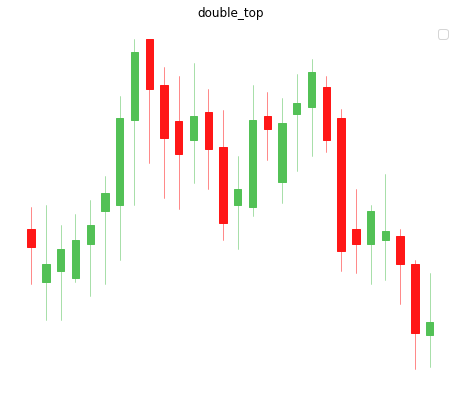

Add, Y o N ? or save to create .csv


KeyboardInterrupt: ignored

In [ ]:
# Open file of one of the markets to be analyzed
df = pd.read_csv('/content/drive/MyDrive/Tesis de grado/datos/Datos sin procesar/QuantDataManager/EURUSD_M1_UTCMinus03-M1.csv', 
                 header=0, names=["date","time","open","max","min","close","volumen"])

# Name of the market
currency = 'EURUSD'

# Add "body" field, being the difference between the closing and opening of the Japanese candlesticks.
df['body'] = np.where(df['close'] >= df['open'],
                               abs(df.close - df.open)/2 + df.open,
                               abs(df.close - df.open)/2 + df.close)

# Take the set of candles that appear in the imported dataset
df_copy = df.iloc[0:3900000].copy() 

# Size of the window in which the pattern is observed 
window_size = 28 
set_values_dt(window_size)  
set_values_sh(window_size) 

# Name of pattern to be labeled
patternTag = 'double_top'

# Look for the possible occurrence of the previously defined pattern based on market movements
df_copy[patternTag] = df_copy['body'].rolling(window_size).apply(double_top)

# Print the number of possible patterns detected
allPatternCount = df_copy[patternTag].value_counts()
print(str(allPatternCount))
print("Continue...")
resp = input()


# Run through the detected patterns, one by one, to visually check if they add up to the labeled dataset
new_df = df_copy.loc[df_copy[patternTag] == True]
df_marks = pd.DataFrame()
counter = 0
aux = 1
for index in new_df.index:

  print('Count: '+str(aux)+'/'+str(allPatternCount[1]))

  # Visualize the image of the found pattern
  pattern_show_image(patternTag, df_copy.loc[index-(window_size-1):index,'open':'close'])
  aux += 1

  # Ask for confirmation to add it to a tagged data set
  print("Add, Y o N ? or save to create .csv")
  resp = input()
  if resp == 'y' or resp == 'Y':
    df_marks = df_marks.append(df_copy.loc[index-(window_size-1):index,'open':'close'], ignore_index=True)
    counter += 1
    print('Counter: ' + str(counter) )
  if resp == 'save':
    # Save file .csv
    df_marks.to_csv('patterns_'+str(patternTag)+'_'+str(counter)+'_'+str(counter)+ '_' + str(currency)+'.csv', index=False)   
    print('pattens_'+str(patternTag)+'_'+str(counter)+ '_' + str(currency)+'.csv')
  
